In [1]:
import seaborn as sns
import pylab as rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
import matplotlib 
import pandas as pd 
import numpy as np
from keras.models import Sequential
from keras.layers import Dense, Dropout
from sklearn.preprocessing import MinMaxScaler
from  sklearn.model_selection import TimeSeriesSplit
from keras.callbacks import EarlyStopping
from tcn import TCN
import tensorflow.keras.optimizers as Optimizer
import keras_tuner as kt


2023-10-29 17:59:05.885108: I tensorflow/core/util/port.cc:111] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-10-29 17:59:05.903781: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-10-29 17:59:05.903804: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-10-29 17:59:05.903814: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-10-29 17:59:05.907836: I tensorflow/core/platform/cpu_feature_g

Using TensorFlow backend


In [2]:
df=pd.read_csv('/home/j/usfq/tesis/StockPredictionModels/Data/Complete.csv')
df

,Date,ticker_symbol,p_sentiment,Open,High,Low,Close,unrate,psr,m2,dspic,pce,reer,ir,ffer,tcs,indpro,ccpi
0,2015-01-02,AAPL,0.857156,27.847500,27.860001,26.837500,27.332500,5.7,8.0,11759.1,13224.7,12036.5,106.11,1.881500,0.114839,1069010.0,102.8479,239.811
1,2015-01-02,AMZN,0.731959,15.629000,15.737500,15.348000,15.426000,5.7,8.0,11759.1,13224.7,12036.5,106.11,1.881500,0.114839,1069010.0,102.8479,239.811
2,2015-01-02,GOOG,0.883473,26.378078,26.490770,26.133251,26.168653,5.7,8.0,11759.1,13224.7,12036.5,106.11,1.881500,0.114839,1069010.0,102.8479,239.811
3,2015-01-02,GOOGL,0.908735,26.629999,26.790001,26.393999,26.477501,5.7,8.0,11759.1,13224.7,12036.5,106.11,1.881500,0.114839,1069010.0,102.8479,239.811
4,2015-01-02,MSFT,0.804051,46.660000,47.419998,46.540001,46.759998,5.7,8.0,11759.1,13224.7,12036.5,106.11,1.881500,0.114839,1069010.0,102.8479,239.811
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7531,2019-12-30,AMZN,0.748412,93.699997,94.199997,92.030998,92.344498,3.6,7.3,15416.2,14844.1,14686.3,116.51,1.862857,1.550968,1458485.0,101.6179,265.651
7532,2019-12-30,GOOG,0.676151,67.500000,67.650002,66.700996,66.806999,3.6,7.3,15416.2,14844.1,14686.3,116.51,1.862857,1.550968,1458485.0,101.6179,265.651
7533,2019-12-30,GOOGL,0.705876,67.840500,67.849998,66.891998,66.985497,3.6,7.3,15416.2,14844.1,14686.3,116.51,1.862857,1.550968,1458485.0,101.6179,265.651
7534,2019-12-30,MSFT,0.762997,158.990005,159.020004,156.729996,157.589996,3.6,7.3,15416.2,14844.1,14686.3,116.51,1.862857,1.550968,1458485.0,101.6179,265.651


In [3]:
#turn date into unix time
#df['Date'] = pd.to_datetime(df['Date'])
#df['Date'] = df['Date'].apply(lambda x: x.timestamp())
#df

In [4]:
#generate new dataframes for each ticker_symbol
df_dict={}
for key in df['ticker_symbol'].unique():
    df_dict[key]=df[df['ticker_symbol']==key]
    df_dict[key]=df_dict[key].drop(columns=['ticker_symbol'])
    df_dict[key]=df_dict[key].sort_values(by=['Date']).reset_index(drop=True)
    #df_dict[key]=df_dict[key].drop(columns=['Date'])
    print(key,df_dict[key].shape)
    print(df_dict[key].head(-1))

AAPL (1252, 17)
            Date  p_sentiment       Open       High        Low      Close  \
0     2015-01-02     0.857156  27.847500  27.860001  26.837500  27.332500   
1     2015-01-05     0.744531  27.072500  27.162500  26.352501  26.562500   
2     2015-01-06     0.769826  26.635000  26.857500  26.157499  26.565001   
3     2015-01-07     0.773995  26.799999  27.049999  26.674999  26.937500   
4     2015-01-08     0.770458  27.307501  28.037500  27.174999  27.972500   
...          ...          ...        ...        ...        ...        ...   
1246  2019-12-20     0.775477  70.557503  70.662498  69.639999  69.860001   
1247  2019-12-23     0.759453  70.132500  71.062500  70.092499  71.000000   
1248  2019-12-24     0.742264  71.172501  71.222504  70.730003  71.067497   
1249  2019-12-26     0.670220  71.205002  72.495003  71.175003  72.477501   
1250  2019-12-27     0.760582  72.779999  73.492500  72.029999  72.449997   

      unrate  psr       m2    dspic      pce    reer       

In [5]:
ticker='TSLA'

In [6]:
df=df_dict[ticker].copy()
df.head()

,Date,p_sentiment,Open,High,Low,Close,unrate,psr,m2,dspic,pce,reer,ir,ffer,tcs,indpro,ccpi
0,2015-01-02,0.741818,14.858000,14.883333,14.217333,14.620667,5.7,8.0,11759.1,13224.7,12036.5,106.11,1.8815,0.114839,1069010.0,102.8479,239.811
1,2015-01-05,0.646626,14.303333,14.433333,13.810667,14.006000,5.7,8.0,11759.1,13224.7,12036.5,106.11,1.8815,0.114839,1069010.0,102.8479,239.811
2,2015-01-06,0.696584,14.004000,14.280000,13.614000,14.085333,5.7,8.0,11759.1,13224.7,12036.5,106.11,1.8815,0.114839,1069010.0,102.8479,239.811
3,2015-01-07,0.654833,14.223333,14.318667,13.985333,14.063333,5.7,8.0,11759.1,13224.7,12036.5,106.11,1.8815,0.114839,1069010.0,102.8479,239.811
4,2015-01-08,0.615611,14.187333,14.253333,14.000667,14.041333,5.7,8.0,11759.1,13224.7,12036.5,106.11,1.8815,0.114839,1069010.0,102.8479,239.811


In [7]:
#putting the close column on the last position
df=df[['Date',
'p_sentiment',
 'Open',
 'High',
 'Low',
 'unrate',
 'psr',
 'm2',
 'dspic',
 'pce',
 'reer',
 'ir',
 'ffer',
 'tcs',
 'indpro',
 'ccpi',
  'Close',]]

In [8]:
dates = pd.to_datetime(df['Date'])

In [9]:
cols=list(df)[1:]
cols

['p_sentiment',
 'Open',
 'High',
 'Low',
 'unrate',
 'psr',
 'm2',
 'dspic',
 'pce',
 'reer',
 'ir',
 'ffer',
 'tcs',
 'indpro',
 'ccpi',
 'Close']

In [10]:
df_for_training = df[cols].astype(float)

In [11]:
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(df_for_training)

In [12]:
print(scaled_data)

[[0.78512475 0.27521525 0.24356139 ... 0.77924797 0.         0.26330631]
 [0.57178167 0.24678828 0.21948349 ... 0.77924797 0.         0.23121105]
 [0.68374619 0.23144731 0.21127918 ... 0.77924797 0.         0.23535347]
 ...
 [0.47142104 0.97577552 0.99347221 ... 0.57323507 1.         1.        ]
 [0.38496901 1.         1.         ... 0.57323507 1.         0.99805053]
 [0.44112774 0.97878229 0.97749165 ... 0.57323507 1.         0.9434678 ]]


In [13]:
#split scaled data into training, val and testing
#train_data=scaled_data[0:1000,:]
#val_data=scaled_data[1000:1125,:]
#test_data=scaled_data[1125:,:]

In [14]:
n_future = 1 # Number of days we want to predict into the future
n_past = 7 # Number of past days we want to use to predict the future

In [15]:
X=[]
y=[]
for i in range(n_past, len(scaled_data) - n_future +1):
    X.append(scaled_data[i - n_past:i, 0:df_for_training.shape[1]])
    y.append(scaled_data[i + n_future - 1:i + n_future, len(cols)-1])

In [16]:
#shape of X_s and y_s
X, y = np.array(X), np.array(y)
print(X.shape)
print(y.shape)

(1250, 7, 16)
(1250, 1)


In [17]:
X_train=X[0:1125,:]
X_test=X[1125:,:]
y_train=y[0:1125,:]
y_test=y[1125:,:]

#early stopping

In [18]:
def model_builder(hp):
    model=Sequential()
    hp_ks=hp.Choice('kernel_size', values=[3, 5, 7,10,12,15,20])
    hp_nb=hp.Choice('nb_filters', values=[32, 64, 128, 256,512])
    model.add(
    TCN(
        input_shape=(X_train.shape[1], X_train.shape[2]),
        kernel_size=hp_ks,
        dilations=[1, 2, 4, 8, 16, 32],
        return_sequences=False,
        activation='relu',
        nb_filters=hp_nb,
        padding='causal',
        #dropout_rate=0.25,
        kernel_initializer='he_normal',
    )   
    )
    model.add(Dense(y_train.shape[1]))
    hp_lr=hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])
    hp_wd=hp.Choice('weight_decay', values=[1e-2, 1e-3, 1e-4])
    model.compile(optimizer=Optimizer.Adam(learning_rate=hp_lr,weight_decay=hp_wd),loss='mae',metrics=['mae'])
    return model

In [19]:
tuner = kt.Hyperband(model_builder,
                     objective='val_loss',
                     max_epochs=10,
                     factor=4,
                     project_name='hyperparameter_tuning')
early_stop=EarlyStopping(monitor='val_loss',patience=10)

2023-10-29 17:59:07.154484: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-10-29 17:59:07.164809: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-10-29 17:59:07.164852: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-10-29 17:59:07.166252: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-10-29 17:59:07.166290: I tensorflow/compile

In [20]:
tuner.search(X_train, y_train, epochs=50, validation_split=0.2, callbacks=[early_stop])
best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]


Trial 11 Complete [00h 00m 07s]
val_loss: 0.036546360701322556

Best val_loss So Far: 0.036546360701322556
Total elapsed time: 00h 01m 10s


In [21]:
print(best_hps.values)

{'kernel_size': 10, 'nb_filters': 256, 'learning_rate': 0.01, 'weight_decay': 0.0001, 'tuner/epochs': 10, 'tuner/initial_epoch': 0, 'tuner/bracket': 0, 'tuner/round': 0}


Epoch 1/1000
4/4 [==============================] - 3s 260ms/step - loss: 193.7561 - mae: 193.7561 - val_loss: 0.9999 - val_mae: 0.9999
Epoch 2/1000
4/4 [==============================] - 0s 17ms/step - loss: 0.9533 - mae: 0.9533 - val_loss: 1.3269 - val_mae: 1.3269
Epoch 3/1000
4/4 [==============================] - 0s 17ms/step - loss: 0.9640 - mae: 0.9640 - val_loss: 0.7139 - val_mae: 0.7139
Epoch 4/1000
4/4 [==============================] - 0s 16ms/step - loss: 0.3631 - mae: 0.3631 - val_loss: 0.0733 - val_mae: 0.0733
Epoch 5/1000
4/4 [==============================] - 0s 16ms/step - loss: 0.2421 - mae: 0.2421 - val_loss: 0.1896 - val_mae: 0.1896
Epoch 6/1000
4/4 [==============================] - 0s 17ms/step - loss: 0.0793 - mae: 0.0793 - val_loss: 0.0573 - val_mae: 0.0573
Epoch 7/1000
4/4 [==============================] - 0s 18ms/step - loss: 0.1798 - mae: 0.1798 - val_loss: 0.0985 - val_mae: 0.0985
Epoch 8/1000
4/4 [==============================] - 0s 17ms/step - loss: 0.059

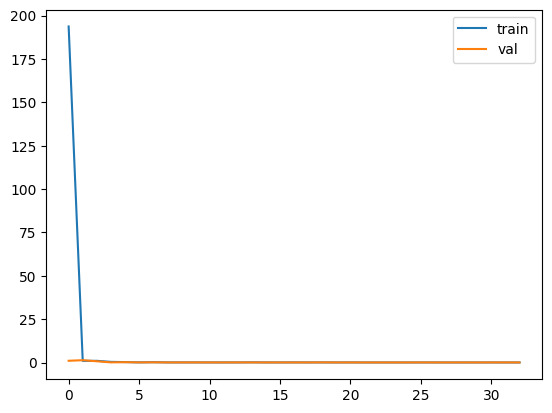

4/4 [==============================] - 0s 27ms/step
MAE: 5.066509860381835
(125,)
(125,)


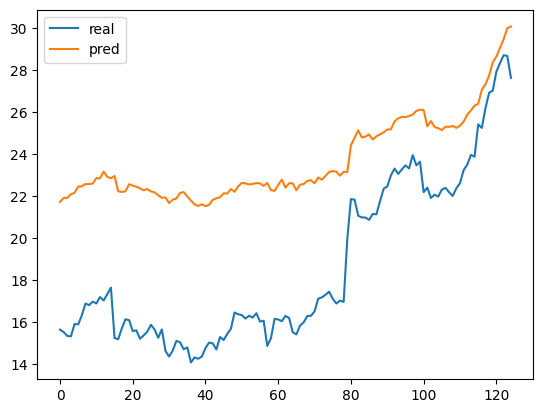

Epoch 1/1000
7/7 [==============================] - 3s 142ms/step - loss: 88.9676 - mae: 88.9676 - val_loss: 0.0896 - val_mae: 0.0896
Epoch 2/1000
7/7 [==============================] - 0s 14ms/step - loss: 0.6729 - mae: 0.6729 - val_loss: 0.5004 - val_mae: 0.5004
Epoch 3/1000
7/7 [==============================] - 0s 15ms/step - loss: 0.3558 - mae: 0.3558 - val_loss: 0.3141 - val_mae: 0.3141
Epoch 4/1000
7/7 [==============================] - 0s 15ms/step - loss: 0.1771 - mae: 0.1771 - val_loss: 0.1829 - val_mae: 0.1829
Epoch 5/1000
7/7 [==============================] - 0s 13ms/step - loss: 0.1546 - mae: 0.1546 - val_loss: 0.0812 - val_mae: 0.0812
Epoch 6/1000
7/7 [==============================] - 0s 14ms/step - loss: 0.0676 - mae: 0.0676 - val_loss: 0.0828 - val_mae: 0.0828
Epoch 7/1000
7/7 [==============================] - 0s 14ms/step - loss: 0.0880 - mae: 0.0880 - val_loss: 0.1542 - val_mae: 0.1542
Epoch 8/1000
7/7 [==============================] - 0s 14ms/step - loss: 0.1758 

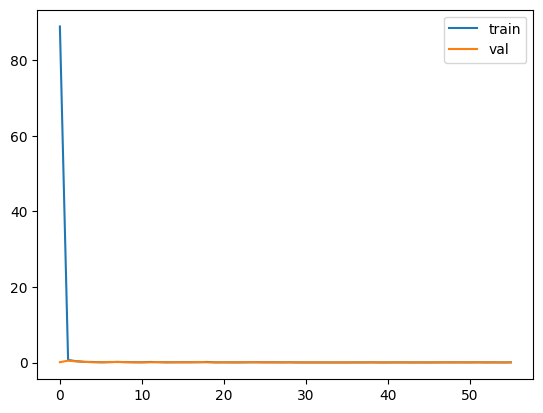

4/4 [==============================] - 0s 2ms/step
MAE: 4.663069905675781
(125,)
(125,)


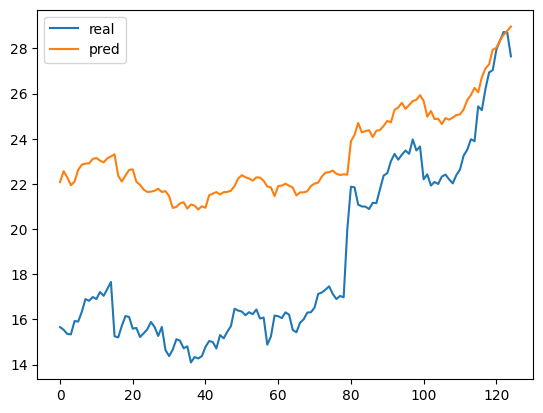

Epoch 1/1000
10/10 [==============================] - 3s 102ms/step - loss: 55.9347 - mae: 55.9347 - val_loss: 0.5239 - val_mae: 0.5239
Epoch 2/1000
10/10 [==============================] - 0s 11ms/step - loss: 0.4486 - mae: 0.4486 - val_loss: 0.7668 - val_mae: 0.7668
Epoch 3/1000
10/10 [==============================] - 0s 12ms/step - loss: 0.2770 - mae: 0.2770 - val_loss: 0.2304 - val_mae: 0.2304
Epoch 4/1000
10/10 [==============================] - 0s 12ms/step - loss: 0.1524 - mae: 0.1524 - val_loss: 0.1350 - val_mae: 0.1350
Epoch 5/1000
10/10 [==============================] - 0s 12ms/step - loss: 0.1309 - mae: 0.1309 - val_loss: 0.0935 - val_mae: 0.0935
Epoch 6/1000
10/10 [==============================] - 0s 12ms/step - loss: 0.2033 - mae: 0.2033 - val_loss: 0.0492 - val_mae: 0.0492
Epoch 7/1000
10/10 [==============================] - 0s 11ms/step - loss: 0.1001 - mae: 0.1001 - val_loss: 0.0632 - val_mae: 0.0632
Epoch 8/1000
10/10 [==============================] - 0s 11ms/step

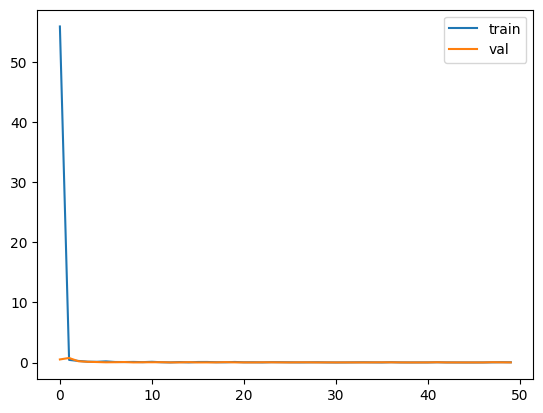

4/4 [==============================] - 0s 2ms/step
MAE: 4.861482136383302
(125,)
(125,)


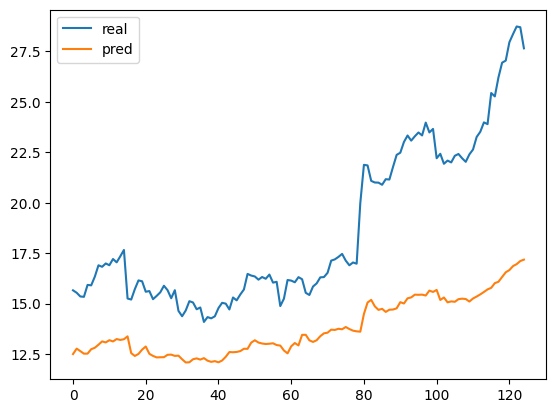

Epoch 1/1000
13/13 [==============================] - 3s 78ms/step - loss: 64.3297 - mae: 64.3297 - val_loss: 0.2589 - val_mae: 0.2589
Epoch 2/1000
13/13 [==============================] - 0s 11ms/step - loss: 0.1225 - mae: 0.1225 - val_loss: 0.2196 - val_mae: 0.2196
Epoch 3/1000
13/13 [==============================] - 0s 11ms/step - loss: 0.2191 - mae: 0.2191 - val_loss: 0.0619 - val_mae: 0.0619
Epoch 4/1000
13/13 [==============================] - 0s 11ms/step - loss: 0.0661 - mae: 0.0661 - val_loss: 0.0466 - val_mae: 0.0466
Epoch 5/1000
13/13 [==============================] - 0s 11ms/step - loss: 0.1013 - mae: 0.1013 - val_loss: 0.0559 - val_mae: 0.0559
Epoch 6/1000
13/13 [==============================] - 0s 11ms/step - loss: 0.0792 - mae: 0.0792 - val_loss: 0.0608 - val_mae: 0.0608
Epoch 7/1000
13/13 [==============================] - 0s 11ms/step - loss: 0.0858 - mae: 0.0858 - val_loss: 0.0618 - val_mae: 0.0618
Epoch 8/1000
13/13 [==============================] - 0s 11ms/step 

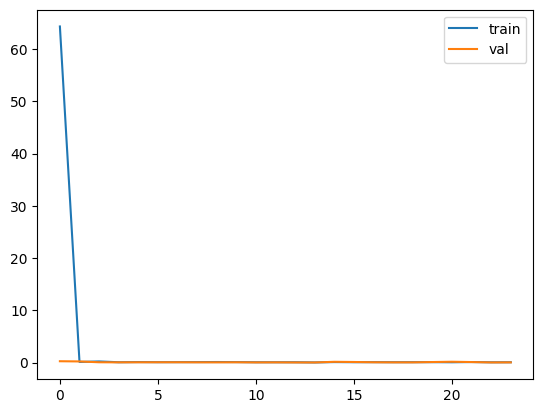

4/4 [==============================] - 0s 2ms/step
MAE: 3.190256071569824
(125,)
(125,)


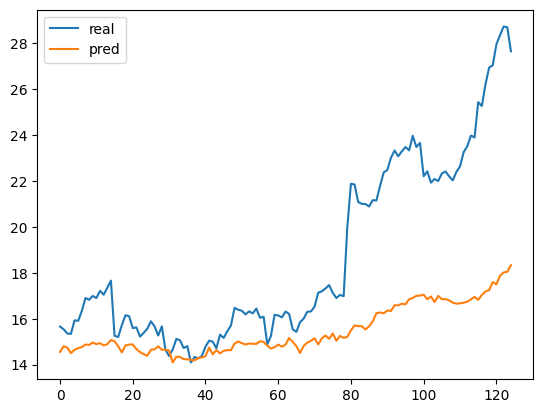

Epoch 1/1000
17/17 [==============================] - 3s 45ms/step - loss: 55.5980 - mae: 55.5980 - val_loss: 0.2769 - val_mae: 0.2769
Epoch 2/1000
17/17 [==============================] - 0s 10ms/step - loss: 0.2148 - mae: 0.2148 - val_loss: 0.2962 - val_mae: 0.2962
Epoch 3/1000
17/17 [==============================] - 0s 10ms/step - loss: 0.1575 - mae: 0.1575 - val_loss: 0.2578 - val_mae: 0.2578
Epoch 4/1000
17/17 [==============================] - 0s 10ms/step - loss: 0.0689 - mae: 0.0689 - val_loss: 0.1138 - val_mae: 0.1138
Epoch 5/1000
17/17 [==============================] - 0s 11ms/step - loss: 0.1069 - mae: 0.1069 - val_loss: 0.1164 - val_mae: 0.1164
Epoch 6/1000
17/17 [==============================] - 0s 11ms/step - loss: 0.1030 - mae: 0.1030 - val_loss: 0.1593 - val_mae: 0.1593
Epoch 7/1000
17/17 [==============================] - 0s 10ms/step - loss: 0.1661 - mae: 0.1661 - val_loss: 0.1639 - val_mae: 0.1639
Epoch 8/1000
17/17 [==============================] - 0s 10ms/step 

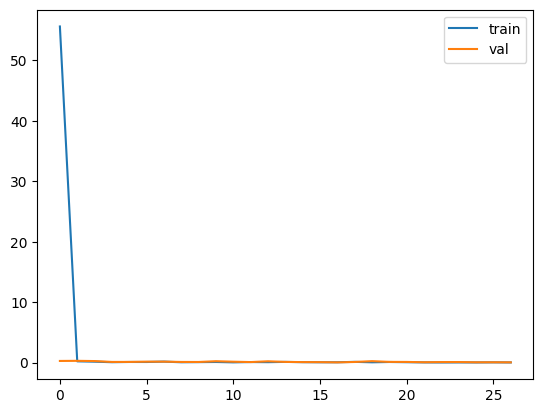

4/4 [==============================] - 0s 2ms/step
MAE: 0.8371993992788084
(125,)
(125,)


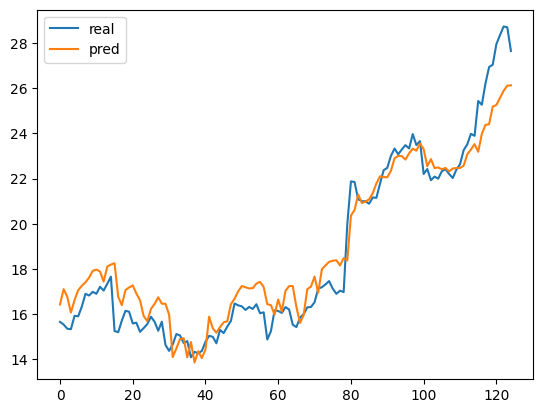

Epoch 1/1000
20/20 [==============================] - 3s 45ms/step - loss: 29.0082 - mae: 29.0082 - val_loss: 0.0646 - val_mae: 0.0646
Epoch 2/1000
20/20 [==============================] - 0s 10ms/step - loss: 0.1634 - mae: 0.1634 - val_loss: 0.4191 - val_mae: 0.4191
Epoch 3/1000
20/20 [==============================] - 0s 9ms/step - loss: 0.1696 - mae: 0.1696 - val_loss: 0.0953 - val_mae: 0.0953
Epoch 4/1000
20/20 [==============================] - 0s 10ms/step - loss: 0.2279 - mae: 0.2279 - val_loss: 0.2316 - val_mae: 0.2316
Epoch 5/1000
20/20 [==============================] - 0s 10ms/step - loss: 0.1466 - mae: 0.1466 - val_loss: 0.1066 - val_mae: 0.1066
Epoch 6/1000
20/20 [==============================] - 0s 9ms/step - loss: 0.1130 - mae: 0.1130 - val_loss: 0.2172 - val_mae: 0.2172
Epoch 7/1000
20/20 [==============================] - 0s 10ms/step - loss: 0.0662 - mae: 0.0662 - val_loss: 0.0542 - val_mae: 0.0542
Epoch 8/1000
20/20 [==============================] - 0s 9ms/step - l

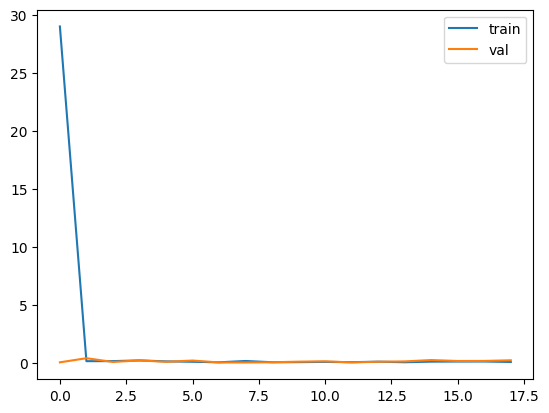

4/4 [==============================] - 0s 2ms/step
MAE: 3.4137658711621093
(125,)
(125,)


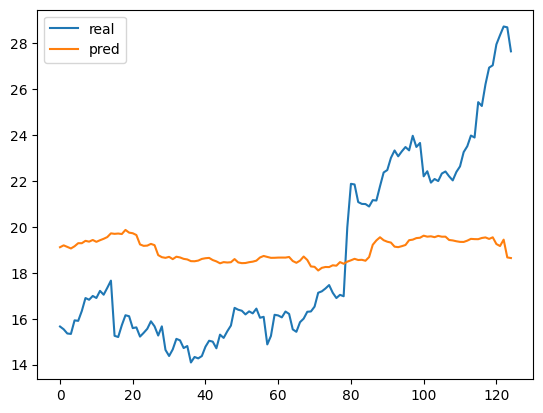

Epoch 1/1000
23/23 [==============================] - 3s 42ms/step - loss: 26.7595 - mae: 26.7595 - val_loss: 0.1800 - val_mae: 0.1800
Epoch 2/1000
23/23 [==============================] - 0s 10ms/step - loss: 0.2028 - mae: 0.2028 - val_loss: 0.0724 - val_mae: 0.0724
Epoch 3/1000
23/23 [==============================] - 0s 10ms/step - loss: 0.2388 - mae: 0.2388 - val_loss: 0.1322 - val_mae: 0.1322
Epoch 4/1000
23/23 [==============================] - 0s 10ms/step - loss: 0.1528 - mae: 0.1528 - val_loss: 0.0858 - val_mae: 0.0858
Epoch 5/1000
23/23 [==============================] - 0s 10ms/step - loss: 0.1038 - mae: 0.1038 - val_loss: 0.2053 - val_mae: 0.2053
Epoch 6/1000
23/23 [==============================] - 0s 10ms/step - loss: 0.1017 - mae: 0.1017 - val_loss: 0.1711 - val_mae: 0.1711
Epoch 7/1000
23/23 [==============================] - 0s 10ms/step - loss: 0.0805 - mae: 0.0805 - val_loss: 0.0510 - val_mae: 0.0510
Epoch 8/1000
23/23 [==============================] - 0s 10ms/step 

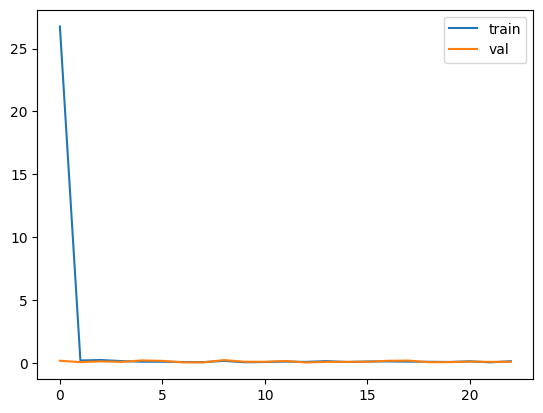

4/4 [==============================] - 0s 2ms/step
MAE: 3.3897496515312504
(125,)
(125,)


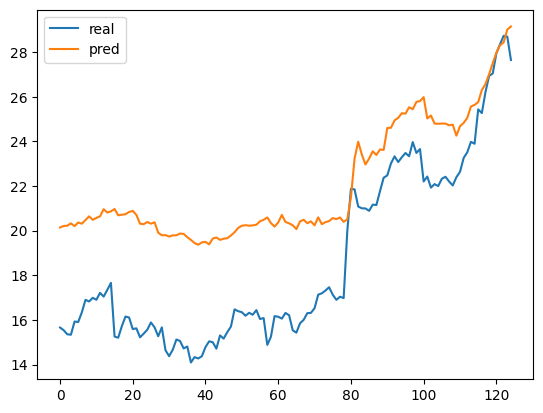

Epoch 1/1000
26/26 [==============================] - 3s 43ms/step - loss: 21.9496 - mae: 21.9496 - val_loss: 0.1656 - val_mae: 0.1656
Epoch 2/1000
26/26 [==============================] - 0s 10ms/step - loss: 0.1246 - mae: 0.1246 - val_loss: 0.0645 - val_mae: 0.0645
Epoch 3/1000
26/26 [==============================] - 0s 10ms/step - loss: 0.1438 - mae: 0.1438 - val_loss: 0.0480 - val_mae: 0.0480
Epoch 4/1000
26/26 [==============================] - 0s 10ms/step - loss: 0.0876 - mae: 0.0876 - val_loss: 0.0401 - val_mae: 0.0401
Epoch 5/1000
26/26 [==============================] - 0s 10ms/step - loss: 0.1502 - mae: 0.1502 - val_loss: 0.0729 - val_mae: 0.0729
Epoch 6/1000
26/26 [==============================] - 0s 10ms/step - loss: 0.0966 - mae: 0.0966 - val_loss: 0.1216 - val_mae: 0.1216
Epoch 7/1000
26/26 [==============================] - 0s 10ms/step - loss: 0.1964 - mae: 0.1964 - val_loss: 0.3259 - val_mae: 0.3259
Epoch 8/1000
26/26 [==============================] - 0s 10ms/step 

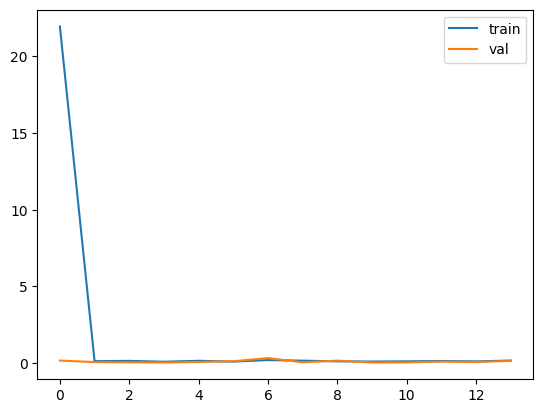

4/4 [==============================] - 0s 3ms/step
MAE: 7.030705005035156
(125,)
(125,)


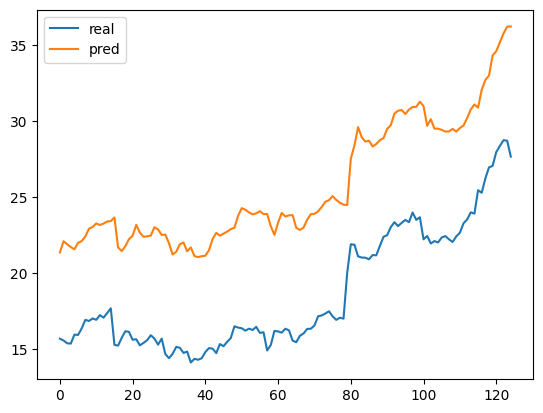

Epoch 1/1000
29/29 [==============================] - 3s 39ms/step - loss: 19.9178 - mae: 19.9178 - val_loss: 0.1612 - val_mae: 0.1612
Epoch 2/1000
29/29 [==============================] - 0s 10ms/step - loss: 0.1961 - mae: 0.1961 - val_loss: 0.0764 - val_mae: 0.0764
Epoch 3/1000
29/29 [==============================] - 0s 10ms/step - loss: 0.0859 - mae: 0.0859 - val_loss: 0.0461 - val_mae: 0.0461
Epoch 4/1000
29/29 [==============================] - 0s 10ms/step - loss: 0.0944 - mae: 0.0944 - val_loss: 0.0524 - val_mae: 0.0524
Epoch 5/1000
29/29 [==============================] - 0s 10ms/step - loss: 0.1685 - mae: 0.1685 - val_loss: 0.0837 - val_mae: 0.0837
Epoch 6/1000
29/29 [==============================] - 0s 9ms/step - loss: 0.1585 - mae: 0.1585 - val_loss: 0.0672 - val_mae: 0.0672
Epoch 7/1000
29/29 [==============================] - 0s 10ms/step - loss: 0.0945 - mae: 0.0945 - val_loss: 0.0469 - val_mae: 0.0469
Epoch 8/1000
29/29 [==============================] - 0s 10ms/step -

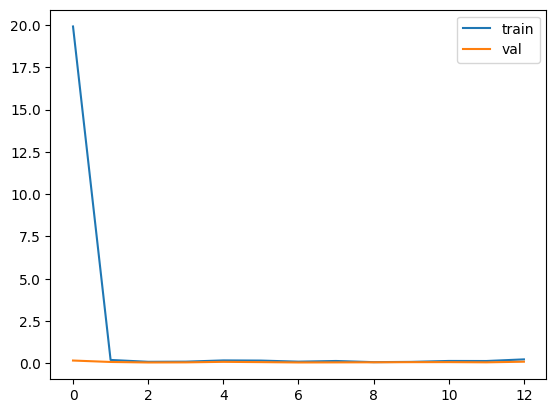

4/4 [==============================] - 0s 2ms/step
MAE: 2.0976232930371093
(125,)
(125,)


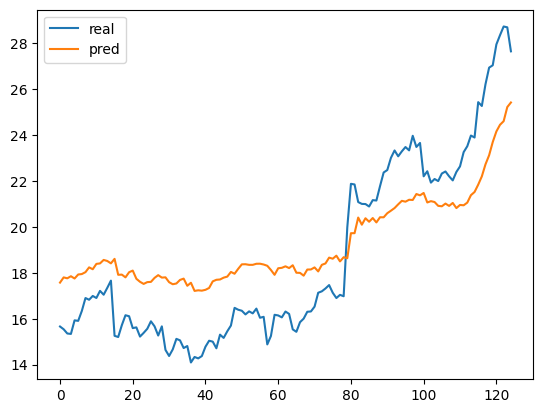

Epoch 1/1000
32/32 [==============================] - 3s 37ms/step - loss: 24.7139 - mae: 24.7139 - val_loss: 0.3600 - val_mae: 0.3600
Epoch 2/1000
32/32 [==============================] - 0s 10ms/step - loss: 0.1661 - mae: 0.1661 - val_loss: 0.1628 - val_mae: 0.1628
Epoch 3/1000
32/32 [==============================] - 0s 10ms/step - loss: 0.1296 - mae: 0.1296 - val_loss: 0.2301 - val_mae: 0.2301
Epoch 4/1000
32/32 [==============================] - 0s 10ms/step - loss: 0.1023 - mae: 0.1023 - val_loss: 0.2805 - val_mae: 0.2805
Epoch 5/1000
32/32 [==============================] - 0s 11ms/step - loss: 0.1454 - mae: 0.1454 - val_loss: 0.2023 - val_mae: 0.2023
Epoch 6/1000
32/32 [==============================] - 0s 10ms/step - loss: 0.0963 - mae: 0.0963 - val_loss: 0.2327 - val_mae: 0.2327
Epoch 7/1000
32/32 [==============================] - 0s 9ms/step - loss: 0.1049 - mae: 0.1049 - val_loss: 0.1191 - val_mae: 0.1191
Epoch 8/1000
32/32 [==============================] - 0s 10ms/step -

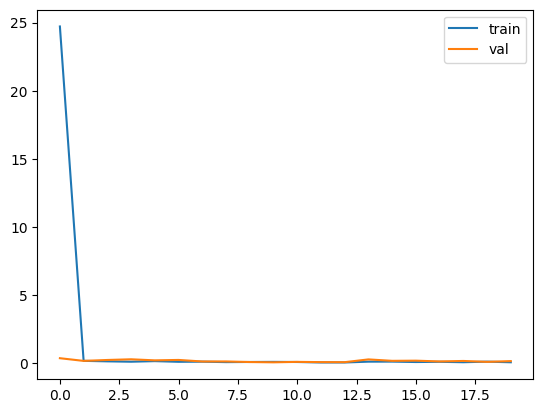

4/4 [==============================] - 0s 3ms/step
MAE: 4.727238276824706
(125,)
(125,)


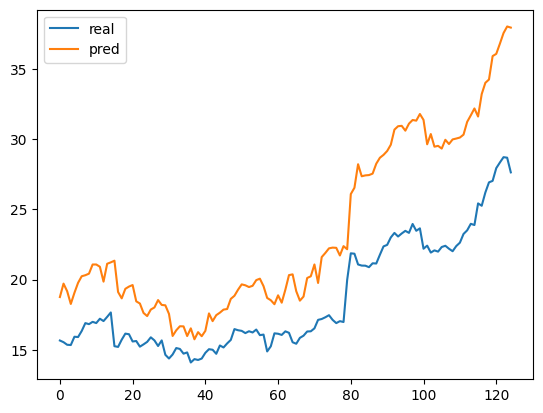

In [22]:
tscv = TimeSeriesSplit(n_splits=10)
y_test=np.repeat(y_test,16,axis=1)
y_test=scaler.inverse_transform(y_test)[:,-1] 
for train_index, val_index in tscv.split(X_train):
    early_stop=EarlyStopping(monitor='val_loss',patience=10)
    X_train, X_val = X[train_index], X[val_index]
    y_train, y_val = y[train_index], y[val_index]

    model=tuner.hypermodel.build(best_hps)
    history=model.fit(X_train,y_train,epochs=1000,validation_data=(X_val,y_val),shuffle=False, callbacks=[early_stop])
    plt.plot(history.history['loss'],label='train')
    plt.plot(history.history['val_loss'],label='val')
    plt.legend()
    plt.show()
    y_pred=model.predict(X_test)
    y_pred.shape


    pred=np.repeat(y_pred,16,axis=1)
    pred=scaler.inverse_transform(pred)[:,-1]

    #show MAE in prediction and real
    print('MAE:', np.mean(np.abs(pred-y_test)))
    print(pred.shape)
    print(y_test.shape)

    #plotting the results
    plt.plot(y_test, label='real')
    plt.plot(pred, label='pred') 
    plt.legend()
    plt.show()
